##### PyMC3 Examples

# GLM Model Selection


**A minimal reproducable example of Model Selection using DIC, WAIC and Bayes Factor.**

+ This example evaluates two different regression models and declares which has the better fit according to a Bayes Factor comparison.
+ The example is adapted specifically from Jake Vanderplas' [recent blogpost](https://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/) on model selection, for which he used an emcee sampler and numpy-based likelihood. The main purpose of this Notebook is to create a PyMC3-based version.
+ See also this question on [Cross Validated](http://stats.stackexchange.com/questions/161082/bayesian-model-selection-in-pymc3) 
+ The dataset is tiny and generated within this Notebook. It contains errors in the measured value (y) only.


**Note:**

+ Python 3.4 project using latest available [PyMC3](https://github.com/pymc-devs/pymc3)
+ Developed using [ContinuumIO Anaconda](https://www.continuum.io/downloads) distribution on a Macbook Pro 3GHz i7, 16GB RAM, OSX 10.10.5.  
+ Finally, if runs become unstable or Theano throws weird errors, try clearing the cache `$> theano-cache clear` and rerunning the notebook.


**Package Requirements (shown as a conda-env YAML):**
```
$> less conda_env_pymc3_examples.yml

name: pymc3_examples
    channels:
      - defaults
    dependencies:
      - python=3.4
      - ipython
      - ipython-notebook
      - ipython-qtconsole
      - numpy
      - scipy
      - matplotlib
      - pandas
      - seaborn
      - patsy  
      - pip

$> conda env create --file conda_env_pymc3_examples.yml

$> source activate pymc3_examples

$> pip install --process-dependency-links git+https://github.com/pymc-devs/pymc3

```

# Setup

In [1]:
%matplotlib inline
%qtconsole --colors=linux

import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import fmin_powell
from scipy import integrate
import pymc3 as pm
import theano as thno
import theano.tensor as T 

from IPython.html.widgets import interactive, fixed

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
rndst = np.random.RandomState(0)

## Local Functions

In [11]:
def generate_data(n=20, p=0, a=1, b=1, c=0, latent_sigma_y=20):
    ''' 
    Create an example dataset based on a very simple model that we might
    imagine is a noisy physical process:
        1. random x values within a range
        2. latent error aka inherent noise in y
        3. optional outliers from unknown sources

    Model form: y ~ a + bx + cx^2 + e
    
    NOTE: latent_sigma_y is used to create a normally distributed,
    'latent error' aka 'inherent noise' in the 'physical process' 
    generating thses values, rather than experimental measurement error. 
    Please don't use the returned `latent_error` values in inferential 
    models, it's there for interest only.
    '''
    
    df = pd.DataFrame({'x':rndst.randint(0,100,n)})
    df['latent_error'] = rndst.normal(0,latent_sigma_y,n)
    df['outlier'] = rndst.binomial(1,p,n)

    bimdl = np.append(rndst.normal(-.4,0.1,100), np.random.normal(.4,0.1,100))
    df['outlier_adj'] = rndst.choice(bimdl, n, replace=False)
                
    ## create linear model
    df['y'] = a + b*(df['x']) + c*(df['x'])**2 + df['latent_error']
   
    ## add extreme noise for outliers
    df['y'] = df['y'] + (df['outlier'] * df['outlier_adj'] * df['y'])

    ## round and return
    for col in ['y','latent_error','x','outlier_adj']:
        df[col] = np.round(df[col],3)
       
    return df


def sketch_data(n=20, p=0, a=-30, b=5, c=0, latent_sigma_y=20):
    ''' Sketch the generated data '''
    
    df = generate_data(n, p, a, b, c, latent_sigma_y)
    ordr = 'linear' if c == 0 else 'quadratic'
    
    g = sns.FacetGrid(df, size=8, hue='outlier', hue_order=[True,False],
                  palette='Set1', legend_out=False)

    _ = g.map(plt.errorbar, 'x', 'y', 'latent_error', marker="o"
              , ls='', elinewidth=0.7).add_legend()

    plotx = np.linspace(df['x'].min() - np.ptp(df['x'])*.1
                        ,df['x'].max() + np.ptp(df['x'])*.1, 100)
    ploty = a + b*plotx + c*plotx**2

    _ = plt.plot(plotx,ploty,'--',alpha=0.8)
    plt.subplots_adjust(top=0.92)
    _ = g.fig.suptitle('Sketch of Data Generation ({})'.format(ordr)
                       ,fontsize=16)
    

def plot_traces(traces, retain=1000):
    ''' Convenience function for plotting traces with overlaid means and values
    '''
    
    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

    
def create_poly_modelspec(k=1):
    ''' Convenience function to create a polynomial modelspec string 
    '''
    return ('y ~ 1 + x ' + ' '.join(['+ np.power(x,{})'.format(j) for j in range(2,k+1)])).strip()

## Draft Data

We'll generate a dummy dataset based on a specific distribution, so we can better evaluate the correctness of the automated model selection later.

Use the interactive plot below to get a feel for the possibilities of data we could generate.

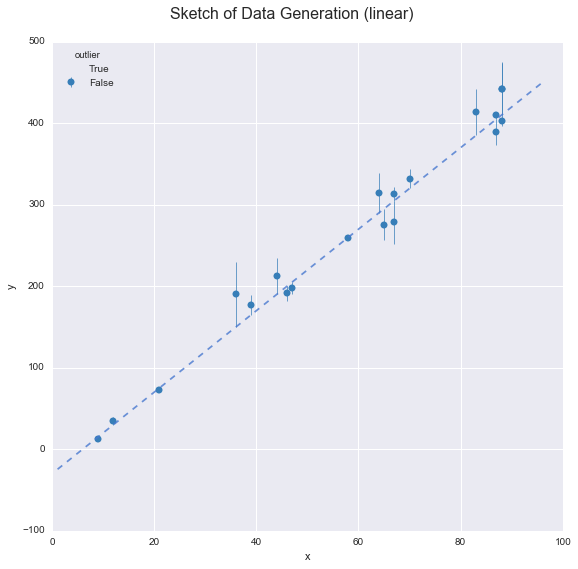

In [4]:
interactive(sketch_data, n=[5,50,5], p=[0,.5,.05], a=[-50,50], b=[-10,10], c=[-10,10]
            ,latent_sigma_y=[0,100,5])

**Observe:**

+ I've shown the `latent_error` in errorbars, but this is for interest only, since this shows the _inherent noise_ in whatever 'physical process' we imagine created the data.
+ There is no _measurement error_.
+ Datapoints created as outliers are shown in **red**, again for interest only.

## Create Dataset for Modelling

We can use the above interactive plot to get a feel for the effect of the params. Now I'll create a fixed dataset to use for the remainder of the Notebook. 

For a start, I'll create a linear model with no outliers. Keep it simple.

In [5]:
df = generate_data(n=10, p=0, a=-30, b=5, latent_sigma_y=60)

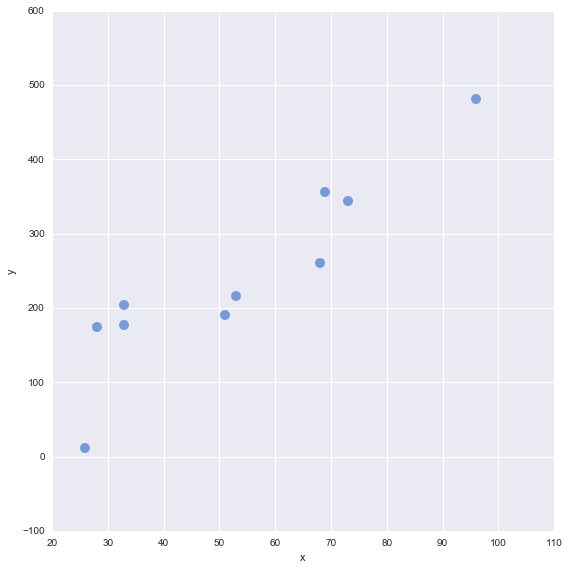

In [6]:
g = sns.lmplot(x='x', y='y', data=df, fit_reg=False, size=8
               ,scatter_kws={'alpha':0.7,'s':100})

**Observe:**

+ This then, is our dataset for the remainder of the notebook. Let's see how well we can fit it!

### Standardize

In [7]:
dfs = df.copy()
dfs['x'] = (df['x'] - df['x'].mean()) / df['x'].std()

In [8]:
## create ranges for later ylim xim
dfs_ylims = (dfs['y'].min() - np.ptp(dfs['y'])/10,dfs['y'].max() + np.ptp(dfs['y'])/10)
dfs_xlims = (dfs['x'].min() - np.ptp(dfs['x'])/10,dfs['x'].max() + np.ptp(dfs['x'])/10)

---

# Create Simple OLS Model

This *linear model* is really simple and conventional:
$$y = a + bx + \epsilon$$



## Define model using ordinary pymc3 method

In [12]:
with pm.Model() as mdl_ols:
        
    ## define Normal priors to give Ridge regression
    b0 = pm.Normal('b0', mu=0, sd=100)
    b1 = pm.Normal('b1', mu=0, sd=100)
 
    ## define Linear model
    yest = b0 + b1 * df['x']

    ## define Normal likelihood with HalfCauchy noise (fat tails, equiv HalfT 1DoF)
    sigma_y = pm.HalfCauchy('sigma_y', beta=10)
    likelihood = pm.Normal('likelihood', mu=yest, sd=sigma_y, observed=df['y'])

    ## sample using NUTS (starting from MAP found using powell)
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=True)
    traces_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

Optimization terminated successfully.
         Current function value: 66.403987
         Iterations: 8
         Function evaluations: 300
 [-----------------100%-----------------] 2000 of 2000 complete in 2.4 sec

##### View Traces after burn-in

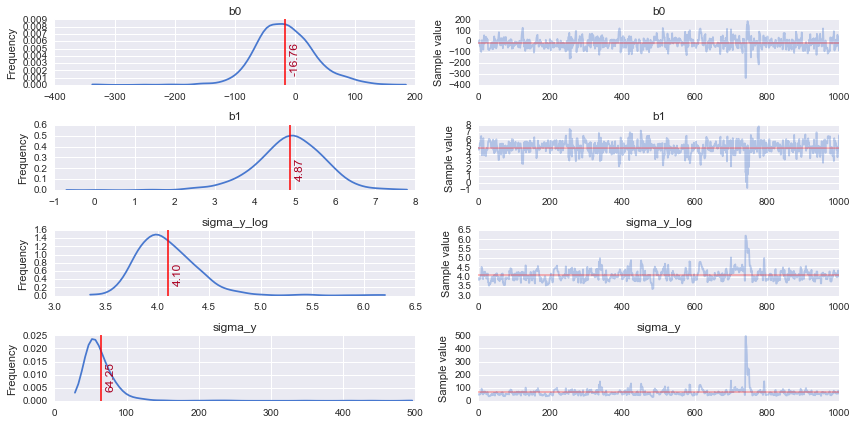

In [13]:
plot_traces(traces_ols, retain=1000)

**Observe:**

+ This simple OLS manages to make fairly good guesses - the data has been generated fairly simply after all - but it does appear to have been fooled by the inherent noise and outliers.


## Define model using pymc3 GLM method

PyMC3 has a quite recently developed method - `glm` - for defining models using a `patsy`-style formula syntax. This seems really useful, especially for defining simple regression models in fewer lines of code. 

I couldn't find a direct comparison in the the examples, so before I launch into using `glm` for the rest of the Notebook, here's the same OLS model as above, defined using `glm`.

In [14]:
with pm.Model() as mdl_ols_glm:

    # setup model with Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.glm('y ~ 1 + x', df, family=pm.glm.families.Normal())
    
    ## sample using NUTS (starting from MAP found using powell)
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=True)
    traces_ols_glm = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

Optimization terminated successfully.
         Current function value: 84.798504
         Iterations: 7
         Function evaluations: 271
 [-----------------100%-----------------] 2000 of 2000 complete in 4.1 sec

##### View Traces after burn-in

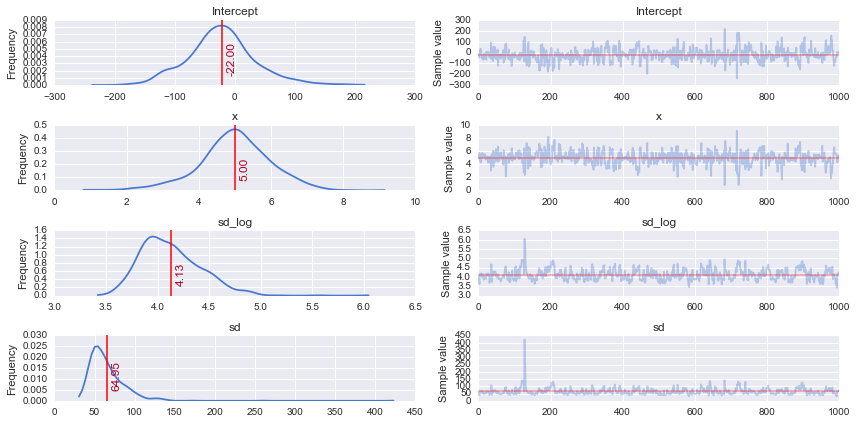

In [15]:
plot_traces(traces_ols_glm, retain=1000)

**Observe:**

+ The output parameters are of course named differently to my custom naming before. Now we have:

    `b0 == Intercept`  
    `b1 == x`  
    `sigma_y_log == sd_log`  
    `sigma_y == sd`  
    
    
+ However, naming aside, this `glm`-defined model appears to behave in a very similar way, and find pretty much the same parameter values as the conventionally-defined model - any differences are due to the random nature of the sampling.
+ I'll quite happily use the `glm` syntax for further models below.

---

# Create Higher-Order OLS Models

Back to the real purpose of this Notebook: demonstrate model selection using Bayes Factor

In [16]:
models, traces = OrderedDict(), OrderedDict()

for k in range(1,6):

    nm = 'k{}'.format(k)
    fml = create_poly_modelspec(k)
    
    with pm.Model() as models[nm]:

        print('\nRunning: {}'.format(nm))
        # setup model with Normal likelihood (which uses HalfCauchy for error prior)
        pm.glm.glm(fml, dfs, family=pm.glm.families.Normal())

        ## sample using NUTS (starting from MAP found using powell)
        start_MAP = pm.find_MAP(fmin=fmin_powell, disp=False)
        traces[nm] = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)    


Running: k1
 [-----------------100%-----------------] 2000 of 2000 complete in 3.0 sec
Running: k2
 [-----------------100%-----------------] 2000 of 2000 complete in 3.2 sec
Running: k3
 [-----------------100%-----------------] 2000 of 2000 complete in 4.8 sec
Running: k4
 [-----------------100%-----------------] 2000 of 2000 complete in 14.6 sec
Running: k5
 [-----------------100%-----------------] 2000 of 2000 complete in 44.0 sec
Running: k6
 [-----------------100%-----------------] 2000 of 2000 complete in 217.4 sec
Running: k7
 [-----------------100%-----------------] 2000 of 2000 complete in 899.0 sec

NOTE: Screenshot of times taken. k7 is really expensive

<img src="img/k7_times.png" width=540></img>

##### Compare likelihoods

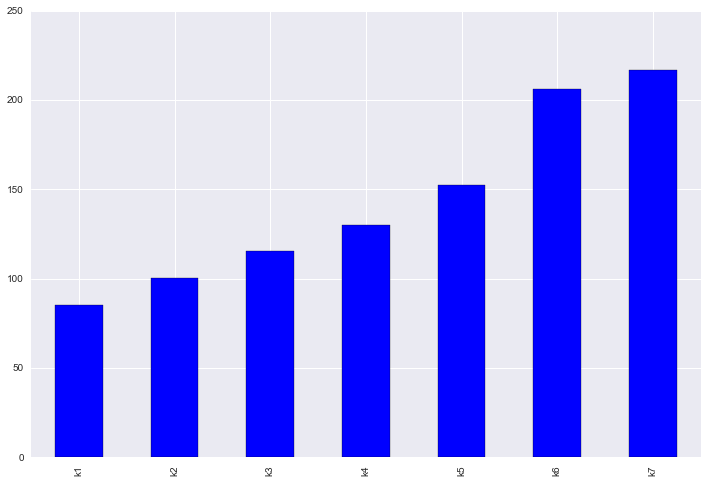

In [17]:
## get negative log likelioods straight from model.logp

loglks = OrderedDict()

for nm, mdl in models.items():
    loglks[nm] = -mdl.logp(pm.df_summary(traces[nm])['mean'].to_dict())

dfll = pd.DataFrame.from_dict(loglks, orient='index')
dfll.rename(columns={0:'loglikelihood'}, inplace=True)
ax = dfll.plot(kind='bar', legend=False)

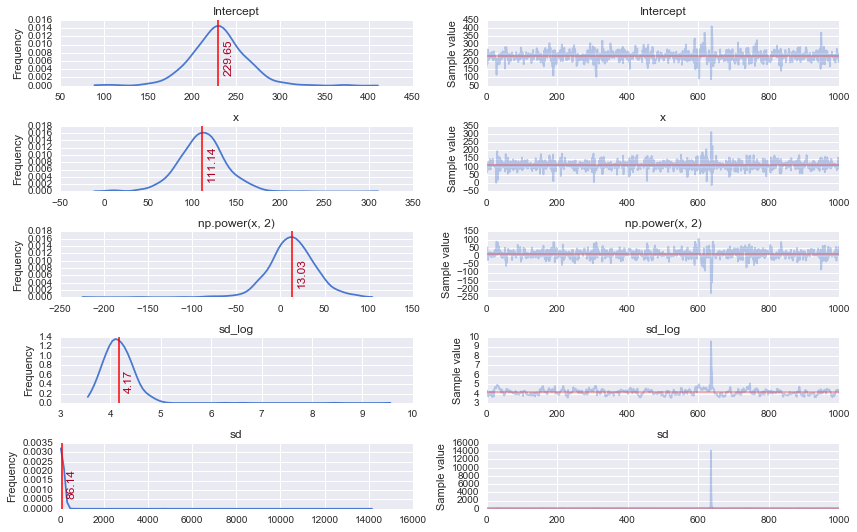

In [18]:
plot_traces(traces['k2'])

### View Posterior Predictive Fit

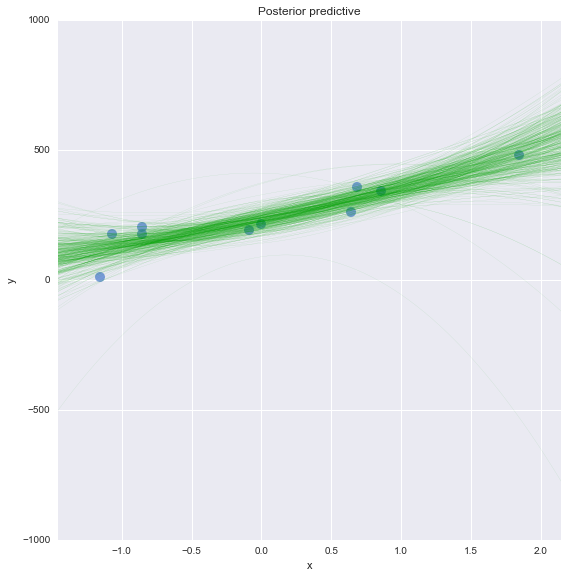

In [48]:
g = sns.lmplot(x='x', y='y', data=dfs, fit_reg=False, size=8
               ,scatter_kws={'alpha':0.7,'s':100})

def lm(x, s):
    return s['Intercept'] \
            + s['x']*x \
            + s['np.power(x, 2)']*np.power(x,2)
#             + s['np.power(x, 3)']*np.power(x,3) \
#             + s['np.power(x, 4)']*np.power(x,4) \
#             + s['np.power(x, 5)']*np.power(x,5) \
#             + s['np.power(x, 6)']*np.power(x,6) \
#             + s['np.power(x, 7)']*np.power(x,7)

pm.glm.plot_posterior_predictive(traces['k2'][-1000:]
        ,eval=np.linspace(dfs_xlims[0], dfs_xlims[1], 200)
        ,lm=lm, samples=500, color='#00AA00', alpha=.2)

# _ = g.axes[0][0].set_ylim(dfs_ylims)
_ = g.axes[0][0].set_xlim(dfs_xlims)

---

# Calculate Deviance Information Criterion (DIC)

##### Manual way, probably error-prone

In [111]:
dftrc = pm.trace_to_dataframe(traces['k1'])
trc_logp = dftrc.apply(lambda x: models['k1'].logp(x.to_dict()), axis=1)
mean_deviance = -2 * trc_logp.mean(0)
mean_deviance

173.72017012898226

In [112]:
deviance_at_mean = -2 * mdl.logp(dftrc.mean(0).to_dict())
deviance_at_mean

170.48309086699771

In [113]:
dic_k1 = 2 * mean_deviance - deviance_at_mean
dic_k1

176.95724939096681

##### Or we could use the newly created function in `stats.py`, much better!

In [114]:
pm.stats.dic(model=models['k1'], trace=traces['k1'])

176.95724939096692

##### Lets loop through all the models and calculate the DIC

In [124]:
dic_values = OrderedDict()
for nm in models.keys():
    dic_values[nm] = pm.stats.dic(model=models[nm], trace=traces[nm])
    
df_dic = pd.DataFrame.from_dict(dic_values, orient='index')
df_dic.rename(columns={0:'DIC'}, inplace=True)

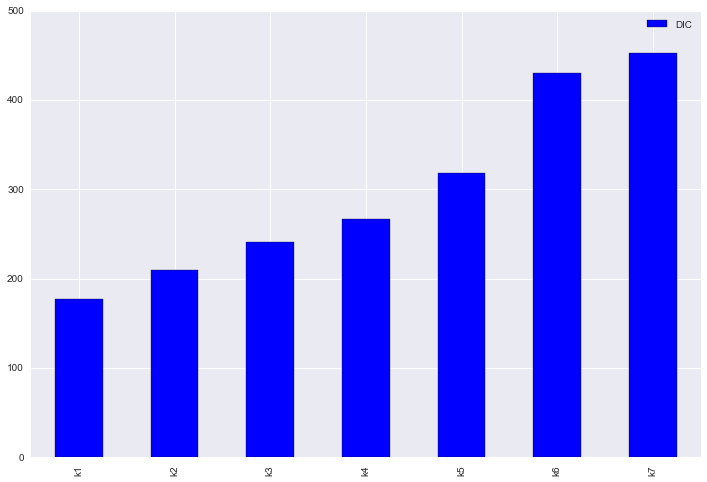

In [123]:
ax = df_dic.plot(kind='bar')

**Observe**

+ The DIC increases monotonically with model complexity, this is great too see!
+ The more complicated the model, the more it would appear we are overfitting.
+ We should prefer the model(s) with lower DIC, which (happily) directly opposes the increasing likelihood we saw earlier. 

---

---

# Bayes Factor

Following text lifted directly from [JakeVDP blogpost](https://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/)

The Bayesian approach proceeds very differently. Recall that the Bayesian model involves computing the odds ratio between two models:

$$O_{21}=\frac{P(M_{2} \;|\; D)}{P(M_{1} \;|\; D)}=\frac{P(D \;|\; M_{2})}{P(D \;|\; M_{1})}\frac{P(M_{2})}{P(M_{1})}$$

Here the ratio $\frac{P(M2)}{P(M1)}$ is the prior odds ratio, and is often assumed to be equal to 1 if no compelling prior evidence favors one model over another. The ratio $\frac{P(D \;|\; M2)}{P(D \;|\; M1)}$ is the **Bayes factor**, and is the key to Bayesian model selection.


The Bayes factor can be computed by evaluating the integral over the parameter likelihood:

$$P(D \;|\; M)=\int_{\Omega}P(D \;|\; \theta,M) \; P(\theta \;|\; M) \;d\theta$$

This integral is over the entire parameter space of the model, and thus can be extremely computationally intensive, especially as the dimension of the model grows beyond a few. 

In [86]:
trc = pm.trace_to_dataframe(traces['k1'])
# xlims, ylims = zip(trc.min(0), trc.max(0))

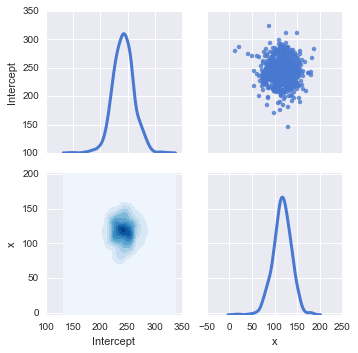

In [84]:
g = sns.PairGrid(trc[-1000:][['Intercept','x']])
_ = g.map_upper(sns.regplot, fit_reg=False)
_ = g.map_lower(sns.kdeplot, shade=True, cmap="Blues")
_ = g.map_diag(sns.kdeplot, lw=3, legend=False)

In [ ]:
func = lambda t1, t0: np.exp(log_posterior([theta0, theta1], data))
return integrate.dblquad(func, xlim[0], xlim[1], lambda x: ylim[0], lambda x: ylim[1])

---

Example originally contributed by Jonathan Sedar 2015-12-30 [github.com/jonsedar](https://github.com/jonsedar)